# Feature selection

Training data contains a lot of correlated, redundant, un-trainable or otherwise likely unnecessary features. Plan here is to work through some standard feature selection techniques from scikit-learn to see if we can come up with a good, minimal feature-set to cary forward for other experiments.

In [1]:
# Change working directory to parent so we can import as we would from __main__.py
print(f'Working directory: ', end = '')
%cd ..

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif

import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs
import configuration as config

Working directory: /mnt/arkk/llm_detector/classifier


## 1. Load and prepare data

In [2]:
# The dataset - omit the file extension, it will be
# added appropriately for the input and output files
dataset_name = 'falcon-7b_scores_v2_10-300_words'

# Input file path
working_hdf5_file = f'{config.DATA_PATH}/{dataset_name}_stage_I.h5'

# Open a connection to the hdf5 dataset via PyTables with Pandas so we can
# load the data from each bin as a dataframe
data_lake = pd.HDFStore(working_hdf5_file)

# Load bin data
data_df = data_lake[f'master']

# Close hdf5 connection
data_lake.close()

data_df.info()
data_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 55774 entries, 0 to 55773
Data columns (total 22 columns):
 #   Column                                                                  Non-Null Count  Dtype  
---  ------                                                                  --------------  -----  
 0   Fragment ID                                                             55774 non-null  int64  
 1   Source record num                                                       55774 non-null  int64  
 2   Fragment length (words)                                                 55774 non-null  int64  
 3   Fragment length (tokens)                                                55774 non-null  int64  
 4   Dataset                                                                 55774 non-null  object 
 5   Source                                                                  55774 non-null  object 
 6   Generator                                                               55774 non-n

,Fragment ID,Source record num,Fragment length (words),Fragment length (tokens),Dataset,Source,Generator,String,Perplexity,Cross-perplexity,...,Writer time (seconds),Reader peak memory (GB),Writer peak memory (GB),Human TF-IDF,Synthetic TF-IDF,TF-IDF score,Synthetic-human TF-IDF exponential gaussian fit Kullback-Leibler score,Human-synthetic TF-IDF exponential gaussian fit Kullback-Leibler score,Synthetic-human TF-IDF kernel density estimate Kullback-Leibler score,Human-synthetic TF-IDF kernel density estimate Kullback-Leibler score
0,20112,5172,89,123,cc_news,human,human,further message by making these detentions slo...,2.826,2.648438,...,2.154994,5.440367,5.421580,-3.186919,-3.011363,1.088142,0.029336,0.096694,0.029336,0.096694
1,41697,9214,60,93,pubmed,synthetic,llama2-13b,patient's hyperglycemia.\nGlucose concentratio...,2.346,2.738281,...,2.123445,5.289928,5.267724,-3.160715,-3.219044,-0.372125,0.108482,0.035199,0.108482,0.035199
2,18174,4638,126,201,cc_news,human,human,"Agustín percussion school, the men glance at e...",3.436,3.402344,...,3.467571,6.958306,6.886296,-2.876598,-2.748349,0.721391,0.035385,0.089849,0.035385,0.089849
3,22944,5944,113,138,cc_news,human,human,"On Aug. 21, a solar eclipse will cut across th...",1.616,1.955078,...,2.621764,5.334320,5.324670,-3.240457,-2.881072,2.199989,0.040583,0.065842,0.040583,0.065842
4,41051,9120,211,336,pubmed,synthetic,llama2-13b,"exposure , however , manganese deficiency can ...",1.910,2.326172,...,4.923284,7.747247,7.677697,-2.846176,-2.859899,-0.078301,0.090459,0.045508,0.090459,0.045508


OK, let's get the data into shape to train a classifier.

In [3]:
# Split the data into training and testing
training_data_df = data_df.sample(frac = 0.7, random_state = 42)
testing_data_df = data_df.drop(training_data_df.index)

# Set length threshold
training_data_df = training_data_df[training_data_df['Fragment length (words)'] > 50].copy()
testing_data_df = testing_data_df[testing_data_df['Fragment length (words)'] > 50].copy()

# Remove rows containing NAN
training_data_df.dropna(inplace = True)
testing_data_df.dropna(inplace = True)

# Drop unnecessary and un-trainable
feature_drops = [
    'Fragment ID',
    'Source record num',
    'Dataset',
    'Generator',
    'String',
    'Reader time (seconds)',
    'Writer time (seconds)',
    'Reader peak memory (GB)',
    'Writer peak memory (GB)'
]

training_data_df.drop(feature_drops, axis = 1, inplace = True)
testing_data_df.drop(feature_drops, axis = 1, inplace = True)

# Split the data into features and labels
labels_train = training_data_df['Source']
features_train_df = training_data_df.drop('Source', axis = 1)

labels_test = testing_data_df['Source']
features_test_df = testing_data_df.drop('Source', axis = 1)

# Encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels_train)
labels_train = label_encoder.transform(labels_train)
labels_test = label_encoder.transform(labels_test)

print(f'Training data: {len(features_train_df)} examples')
print(f'Test data: {len(features_test_df)} examples')

# Grab the original feature names for future reference
feature_column_names = features_train_df.columns
feature_column_names

Training data: 31527 examples
Test data: 13517 examples


Index(['Fragment length (words)', 'Fragment length (tokens)', 'Perplexity',
       'Cross-perplexity', 'Perplexity ratio score', 'Human TF-IDF',
       'Synthetic TF-IDF', 'TF-IDF score',
       'Synthetic-human TF-IDF exponential gaussian fit Kullback-Leibler score',
       'Human-synthetic TF-IDF exponential gaussian fit Kullback-Leibler score',
       'Synthetic-human TF-IDF kernel density estimate Kullback-Leibler score',
       'Human-synthetic TF-IDF kernel density estimate Kullback-Leibler score'],
      dtype='object')

Next, standard scale the data. This is not strictly necessary for a tree-based classifier, but it will be helpful when eyeballing the data.

In [4]:
features_train_df, features_test_df = helper_funcs.standard_scale_data(features_train_df, features_test_df, feature_column_names)

Take a look at the features we are working with:

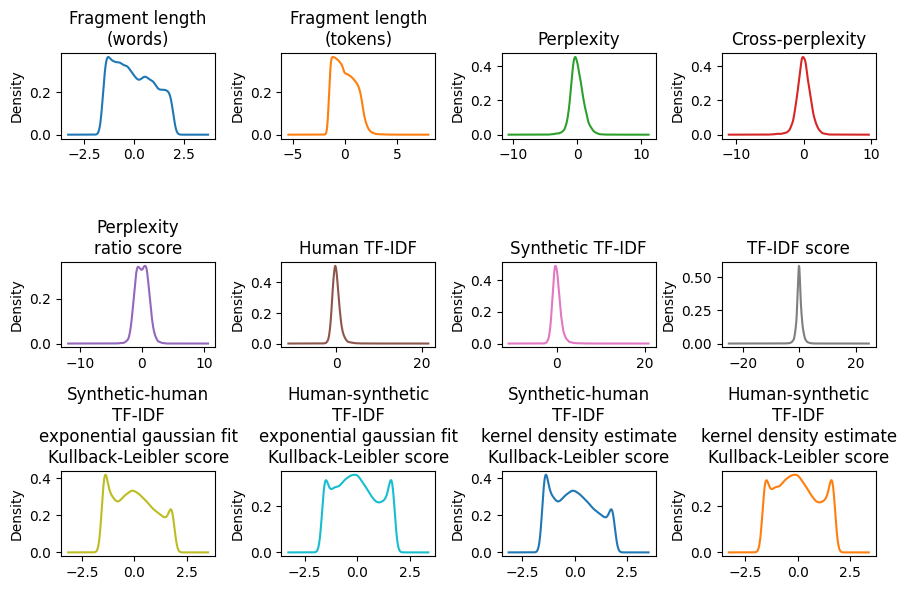

In [5]:
plot_funcs.plot_feature_distributions(features_train_df).show()

Have 12 features for plot:
 0: Fragment length (words)
 1: Fragment length (tokens)
 2: Perplexity
 3: Cross-perplexity
 4: Perplexity ratio score
 5: Human TF-IDF
 6: Synthetic TF-IDF
 7: TF-IDF score
 8: Synthetic-human TF-IDF exponential gaussian fit Kullback-Leibler score
 9: Human-synthetic TF-IDF exponential gaussian fit Kullback-Leibler score
 10: Synthetic-human TF-IDF kernel density estimate Kullback-Leibler score
 11: Human-synthetic TF-IDF kernel density estimate Kullback-Leibler score


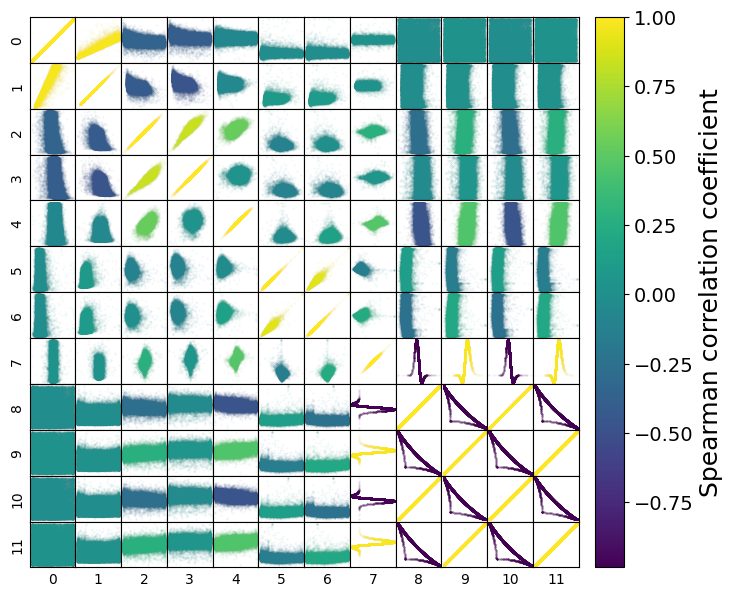

In [6]:
plot_funcs.plot_scatter_matrix(features_train_df).show()

Just for fun let's add some synthetic features to the dataset:

In [7]:
poly_features_train, poly_features_test = helper_funcs.add_poly_features(features_train_df, features_test_df)

Polynomial training data shape: (31527, 91)
Polynomial testing data shape: (13517, 91)


In [8]:
spline_features_train, spline_features_test = helper_funcs.add_spline_features(features_train_df, features_test_df)

Spline training data shape: (31527, 84)
Spline testing data shape: (13517, 84)


## 2. Univariate feature selection

### 2.1. Mutual information
#### 2.1.1 Original feature set

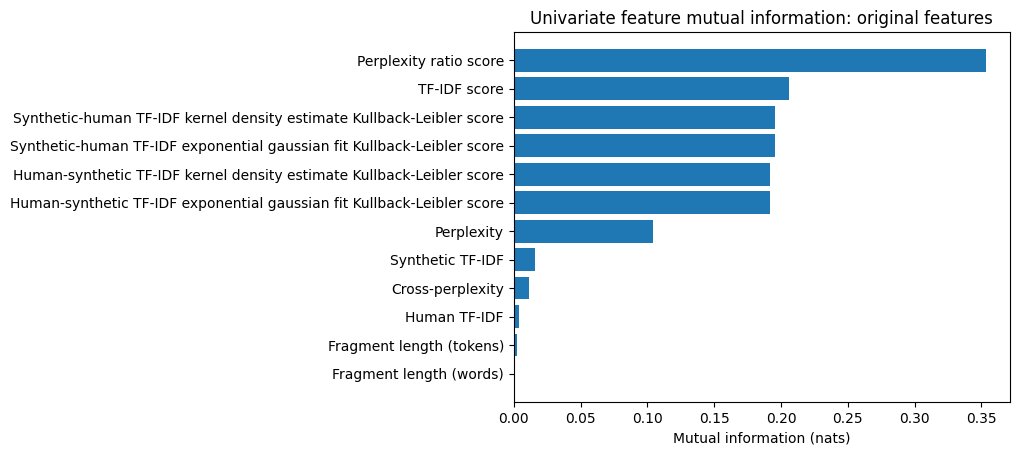

In [9]:
results = mutual_info_classif(features_train_df, labels_train)

univariate_mi_results = {}

for feature, result in zip(feature_column_names, results):
    univariate_mi_results[feature] = result

univariate_mi_results = dict(sorted(univariate_mi_results.items(), key = lambda item: item[1]))

plt.title('Univariate feature mutual information: original features')

plt.barh(
    np.arange(len(univariate_mi_results.values())),
    univariate_mi_results.values(),
    tick_label = list(univariate_mi_results.keys())
)

plt.xlabel('Mutual information (nats)')

plt.show()

#### 2.1.2. Spline synthetic feature set

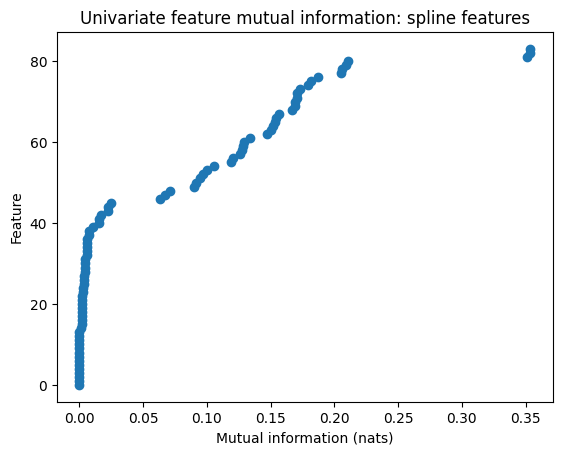

In [10]:
results = mutual_info_classif(spline_features_train, labels_train)

univariate_mi_results = {}

for feature, result in enumerate(results):
    univariate_mi_results[feature] = result

univariate_mi_results = dict(sorted(univariate_mi_results.items(), key = lambda item: item[1]))

plt.title('Univariate feature mutual information: spline features')

plt.scatter(
    univariate_mi_results.values(),
    np.arange(len(univariate_mi_results.values()))
)

plt.xlabel('Mutual information (nats)')
plt.ylabel('Feature')

plt.show()

#### 2.1.3. Polynomial synthetic feature set

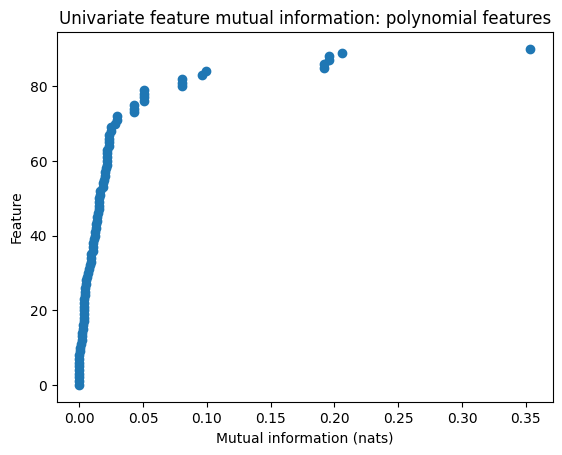

In [11]:
results = mutual_info_classif(poly_features_train, labels_train)

univariate_mi_results = {}

for feature, result in enumerate(results):
    univariate_mi_results[feature] = result

univariate_mi_results = dict(sorted(univariate_mi_results.items(), key=lambda item: item[1]))

plt.title('Univariate feature mutual information: polynomial features')

plt.scatter(
    univariate_mi_results.values(),
    np.arange(len(univariate_mi_results.values()))
)

plt.xlabel('Mutual information (nats)')
plt.ylabel('Feature')

plt.show()

### 2.2. F-Test
#### 2.2.1. Original feature set

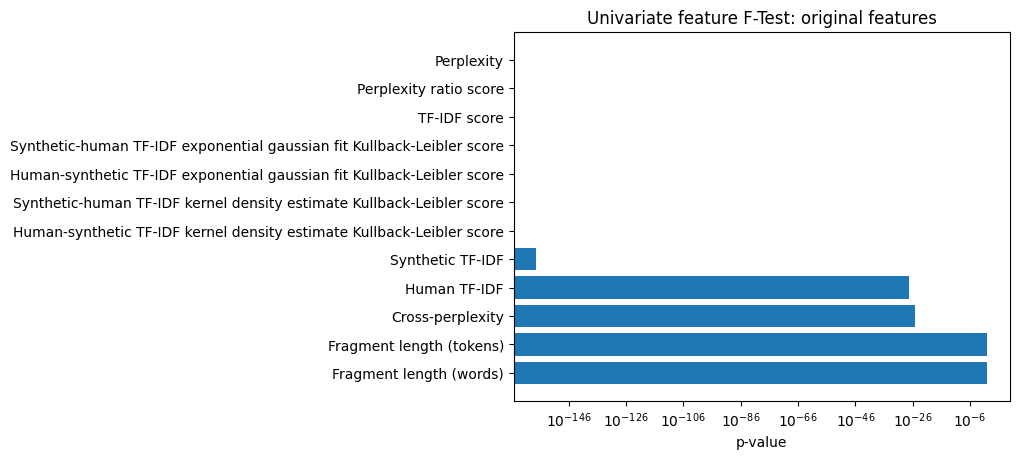

In [12]:
selector = SelectKBest(f_classif, k = 4)
selector.fit(features_train_df, labels_train)

univariate_ftest_results = {}

for feature, result in zip(feature_column_names, selector.pvalues_):
    univariate_ftest_results[feature] = result

univariate_ftest_results = dict(reversed(sorted(univariate_ftest_results.items(), key = lambda item: item[1])))

plt.title('Univariate feature F-Test: original features')

plt.barh(
    np.arange(len(univariate_ftest_results.values())),
    univariate_ftest_results.values(),
   
    tick_label=list(univariate_ftest_results.keys())
)
plt.xscale('log')
plt.xlabel('p-value')

plt.show()

#### 2.2.2. Spline synthetic feature set

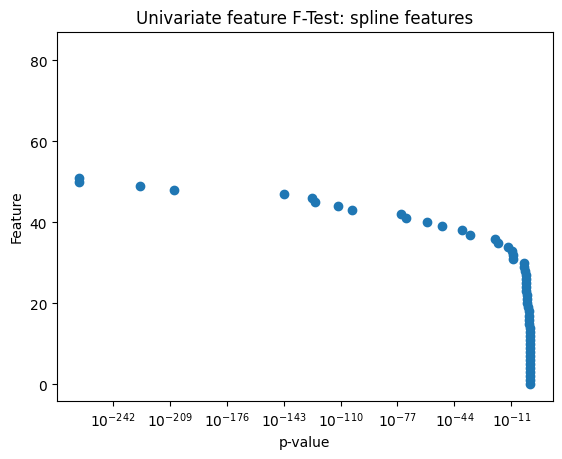

In [13]:
selector = SelectKBest(f_classif, k = 4)
selector.fit(spline_features_train, labels_train)

univariate_ftest_results = {}

for feature, result in enumerate(selector.pvalues_):
    univariate_ftest_results[feature] = result

univariate_ftest_results = dict(reversed(sorted(univariate_ftest_results.items(), key = lambda item: item[1])))

plt.title('Univariate feature F-Test: spline features')

plt.scatter(
    univariate_ftest_results.values(),
    np.arange(len(univariate_ftest_results.values()))
)
plt.xscale('log')
plt.xlabel('p-value')
plt.ylabel('Feature')

plt.show()

#### 2.2.3. Polynomial synthetic feature set

/mnt/arkk/llm_detector/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/mnt/arkk/llm_detector/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


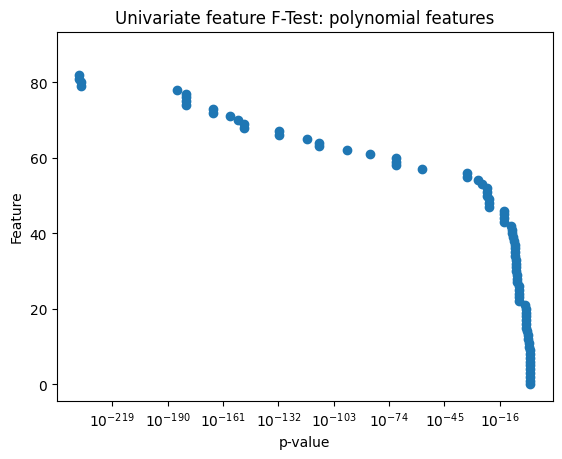

In [14]:
selector = SelectKBest(f_classif, k = 4)
selector.fit(poly_features_train, labels_train)

univariate_ftest_results = {}

for feature, result in enumerate(selector.pvalues_):
    univariate_ftest_results[feature] = result

univariate_ftest_results = dict(reversed(sorted(univariate_ftest_results.items(), key = lambda item: item[1])))

plt.title('Univariate feature F-Test: polynomial features')

plt.scatter(
    univariate_ftest_results.values(),
    np.arange(len(univariate_ftest_results.values()))
)
plt.xscale('log')
plt.xlabel('p-value')
plt.ylabel('Feature')

plt.show()

OK, cool - both methods seem to agree and many of our features are clearly significant. Question is now, do we need all of them? We already know we have some highly correlated/similar features that we could probably afford to loose.

## 3. Recursive feature elimination

In [15]:
cv_folds = 5

### 3.1. Original feature set

Optimal number of features: 8


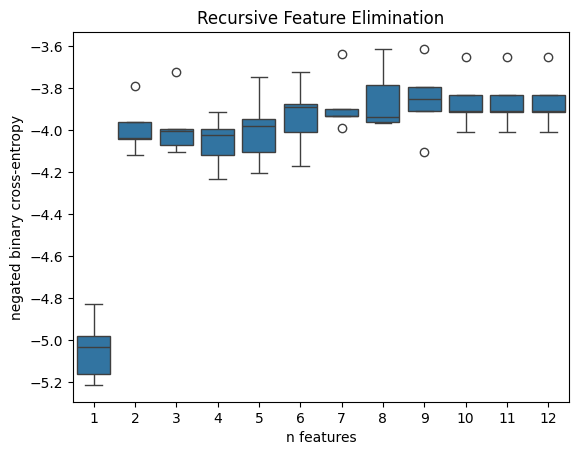

CPU times: user 17.3 s, sys: 1.52 s, total: 18.9 s
Wall time: 7.52 s


In [16]:
%%time

rfecv, cv_results, originals_plt = helper_funcs.recursive_feature_elimination(
    features_train_df = features_train_df,
    labels_train = labels_train,
    cv_folds = cv_folds
)

optimal_feature_count = rfecv.n_features_
originals_plt.show()

### 3.2. Spline synthetic feature set

Optimal number of features: 22


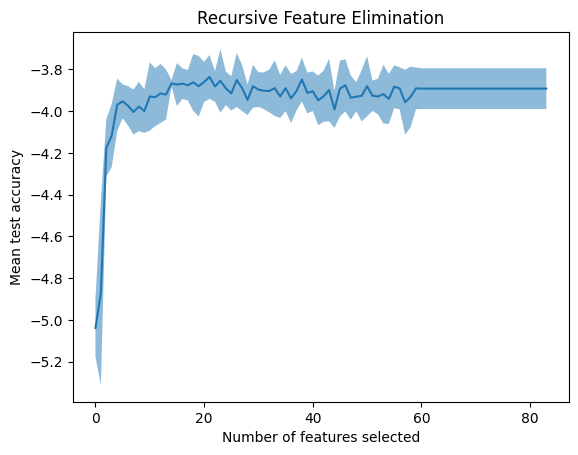

CPU times: user 6min 58s, sys: 890 ms, total: 6min 59s
Wall time: 2min 7s


In [17]:
%%time

spline_rfecv, spline_cv_results, spline_plt = helper_funcs.recursive_feature_elimination(
    features_train_df = spline_features_train, 
    labels_train = labels_train, 
    cv_folds = cv_folds
)

optimal_spline_feature_count = spline_rfecv.n_features_
spline_plt.show()

## 4. Reduced feature set evaluation

After a bunch of fiddling around, it seems like the sweet spot for number of features is around 7 or 8 for the original set and 30 or so for the polynomial set. Though, this seems highly dependent on the number of cross-validation folds and the split method. Also, *RFECV* and *SequentialFeatureSelector* seem to often disagree on exactly what those features should be. I think it's time to generate datasets with those numbers of features and train and evaluate some classifiers.

In [18]:
# Make evaluation metrics scorers
scoring = {
    'binary_cross_entropy': make_scorer(helper_funcs.binary_cross_entropy), 
    'accuracy': make_scorer(helper_funcs.percent_accuracy),
    'false_positive_rate': make_scorer(helper_funcs.false_positive_rate),
    'false_negative_rate': make_scorer(helper_funcs.false_negative_rate)
}

# Dictionary to hold results
results = {
    'Fold': [],
    'Condition': [],
    'Fit time (sec.)': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

# Plots to draw
plots = ['Fit time (sec.)', 'Accuracy (%)', 'False positive rate', 'False negative rate', 'Binary cross-entropy']

### 4.1. Original feature set

Data shape: (31527, 1)
Data shape: (31527, 2)
Data shape: (31527, 3)
Data shape: (31527, 4)
Data shape: (31527, 5)
Data shape: (31527, 6)
Data shape: (31527, 7)
Data shape: (31527, 8)
Data shape: (31527, 9)
Data shape: (31527, 10)
Data shape: (31527, 11)


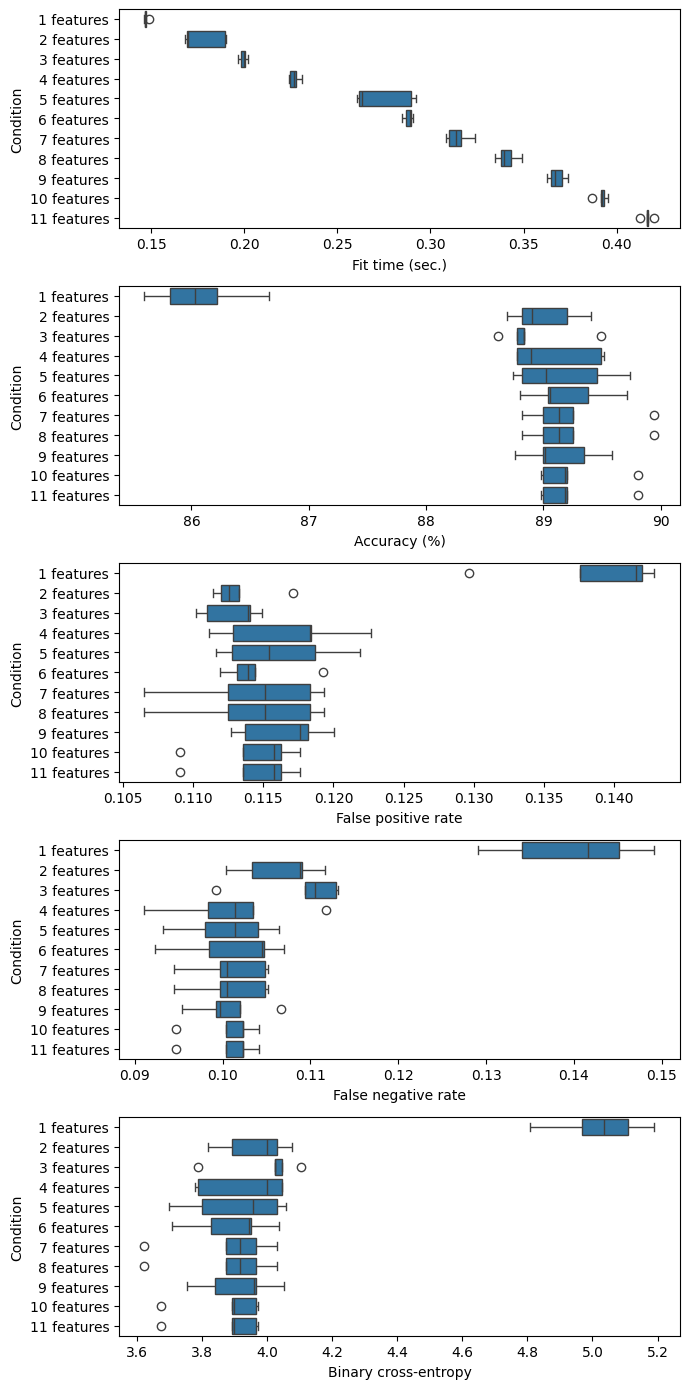

CPU times: user 9.77 s, sys: 1.46 s, total: 11.2 s
Wall time: 2min 53s


In [19]:
%%time

# The feature set sizes to test - for the original features
# test all of the possible feature set sizes
feature_set_sizes = [1,2,3,4,5,6,7,8,9,10,11]

# Cross validation folds to run
cv_folds = 5

# Loop on the feature set sizes
for feature_set_size in feature_set_sizes:

    # Run sequential feature selection for this feature set size
    sfs, fitted_sfs = helper_funcs.sequential_feature_selection(
        features_train = features_train_df, 
        labels_train = labels_train, 
        feature_count = feature_set_size, 
        cv_folds = cv_folds
    )

    feature_set_train = fitted_sfs.transform(features_train_df)
    print(f'Data shape: {feature_set_train.shape}')

    # Instantiate an XGBoost model using the sklearn API
    model = XGBClassifier()

    # Run cross-validation
    scores = cross_validate(
        model,
        feature_set_train,
        labels_train,
        cv = cv_folds,
        n_jobs = -1,
        scoring = scoring
    )

    # Collect the results
    results = helper_funcs.add_cv_scores(results, scores, f'{feature_set_size} features')

plot_funcs.plot_cross_validation(plots, results).show()

### 4.2. Spline synthetic feature set

In [20]:
# Clear the results dictionary
results = {
    'Fold': [],
    'Condition': [],
    'Fit time (sec.)': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

Data shape: (31527, 19)
Data shape: (31527, 20)
Data shape: (31527, 21)
Data shape: (31527, 22)
Data shape: (31527, 23)
Data shape: (31527, 24)


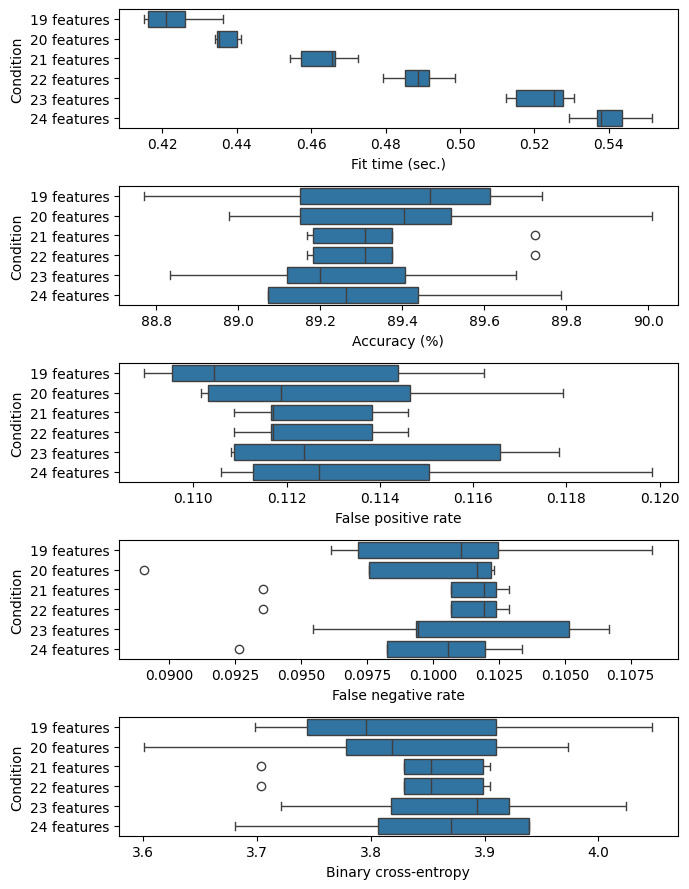

CPU times: user 2min 58s, sys: 26.6 s, total: 3min 24s
Wall time: 1h 7min 20s


In [21]:
%%time

# The feature set sizes to test
feature_set_sizes = np.arange(optimal_spline_feature_count - 3, optimal_spline_feature_count + 3)

# Loop on the feature set sizes
for feature_set_size in feature_set_sizes:

    # Run sequential feature selection for this feature set size
    sfs, fitted_sfs = helper_funcs.sequential_feature_selection(
        features_train = spline_features_train, 
        labels_train = labels_train, 
        feature_count = feature_set_size, 
        cv_folds = cv_folds
    )

    feature_set_train = fitted_sfs.transform(spline_features_train)
    print(f'Data shape: {feature_set_train.shape}')

    # Instantiate an XGBoost model using the sklearn API
    model = XGBClassifier()

    # Run cross-validation
    scores = cross_validate(
        model,
        feature_set_train,
        labels_train,
        cv = cv_folds,
        n_jobs = -1,
        scoring = scoring
    )

    # Collect the results
    results = helper_funcs.add_cv_scores(results, scores, f'{feature_set_size} features')

plot_funcs.plot_cross_validation(plots, results).show()